### Human in the loop

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI

# os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model="llama3-70b-8192")
# llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke("Hello")

print(result)

content="Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?" additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 11, 'total_tokens': 37, 'completion_time': 0.074285714, 'prompt_time': 0.000131949, 'queue_time': 0.052451861, 'total_time': 0.074417663}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'stop', 'logprobs': None} id='run-227134ec-63a2-46fa-bb7e-6dacfb26bf40-0' usage_metadata={'input_tokens': 11, 'output_tokens': 26, 'total_tokens': 37}


In [2]:
def add(a: int, b: int) -> int:
    """
    Add two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The sum of a and b.
    """
    return a + b

def subtract(a: int, b: int) -> int:
    """
    Subtract the second integer from the first integer.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The difference between a and b.
    """
    return a - b

def multiply(a: int, b: int) -> int:
    """
    Multiply two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    """
    return a * b

def divide(a: int, b: int) -> float:
    """
    Divide the first integer by the second integer.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        float: The quotient of a divided by b.

    Raises:
        ValueError: If b is zero.
    """
    if b == 0:
        raise ValueError("Cannot divide by zero")
    return a / b

In [3]:
tools = [add, subtract, multiply, divide]

In [4]:
llm_with_tools = llm.bind_tools(tools)

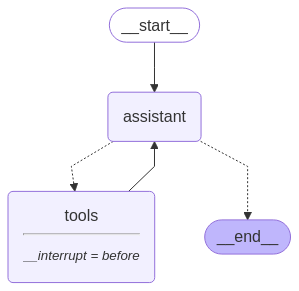

In [5]:
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

# System message
sys_msg = SystemMessage(
    content="You are a helpful assistant task with performing arithematic operations on a set of inputs. "
)

def assistant(state: MessagesState) -> MessagesState:
    return {
        "messages": [
            llm_with_tools.invoke([sys_msg] + state["messages"])
        ]
    }

builder = StateGraph(MessagesState)
# Define the node
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

## Define the edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant", 
    # if the latest message (result) from assistant is a tool call -> tools_condition rotes to tools
    # if the latest message (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
## human in the loop
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
initial_input = {
    "messages": HumanMessage(
            content="Multiply 2 and 3"
    )
}

thread = {"configurable": {"thread_id": "1"}}



In [7]:
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_6kvs)
 Call ID: call_6kvs
  Args:
    a: 2
    b: 3


In [8]:
state = graph.get_state(thread)
state.next

('tools',)

In [9]:
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='0382965c-9164-4773-aa22-537c92147997'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6kvs', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 1356, 'total_tokens': 1404, 'completion_time': 0.15487756, 'prompt_time': 0.050883502, 'queue_time': 0.055442198, 'total_time': 0.205761062}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4a5211e9-3af0-4dab-aac9-addb5081c0b3-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_6kvs', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1356, 'output_tokens': 48, 'total_tokens': 1404})]}, next=('tools',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id':

In [10]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_6kvs)
 Call ID: call_6kvs
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The answer is 6.


In [11]:
state = graph.get_state(thread)
state.next

()

### Edit Human Feedback

In [12]:
graph.update_state(thread, {"messages": [
    HumanMessage(
        content="No, actually Multiply 14 and 5"
    )
]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f026272-aa9d-6977-8004-ea20347e4739'}}

In [ ]:
state = graph.get_state(thread).values


In [15]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

No, actually Multiply 14 and 5


In [16]:
state.next

()

In [17]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

No, actually Multiply 14 and 5
